In [20]:
import argparse
import os
import re
from pathlib import Path
import cv2
import numpy as np
import torch
from PIL import Image
# from model import DCENet
import torchvision
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import PIL
import tensorflow as tf

import sys
sys.path.append(r"C:\Users\Sean Tan\Desktop\zerodce\Zero-DCE\code")
sys.path.append(r"C:\Users\Sean Tan\Desktop\gitasyc\anpr\simple_worker\models")
import utils
sys.path.insert(0, r"C:\Users\Sean Tan\Desktop\gitasyc\anpr\simple_worker\models")
from enhance import perform_image_enhancement, zerodce, DCENet

# import os
# import sys
# import inspect
#
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# sys.path.insert(0, parentdir)



In [2]:
img1 = cv2.imread(r"C:\Users\Sean Tan\Downloads\test1.jpeg")
img2 = cv2.imread(r"C:\Users\Sean Tan\Downloads\test2.jpeg")

In [17]:
def perform_image_enhancement2(image):
    # this is where we modify to depending on implementation

    image = zerodce2(image)
    image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
    image = (image*255).astype(np.uint8)

    return image

In [16]:
def zerodce2(image):
    enh_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    device = torch.device("cpu")
    model = DCENet(return_results=[4, 8])
    model.load_state_dict(
        torch.load(
            r"C:\Users\Sean Tan\Desktop\gitasyc\anpr\simple_worker\models\zero_dce\8LE-color-loss2_best_model.pth",
            map_location=torch.device("cpu"),
        )["model"]
    )
    model.to(device)

    enh_img = torch.from_numpy(np.array(enh_img))
    enh_img = enh_img.float().div(255)
    enh_img = enh_img.permute((2, 0, 1)).contiguous()
    enh_img = enh_img.unsqueeze(0)
    enh_img = enh_img.to(device)
    results, Astack = model(enh_img)
    enhanced_image_base = results[1]

    _, _, h, w = enhanced_image_base.shape

    # this part is re-reading raw image since enhanced_image_base is just to get exposure levels
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = cv2.resize(image, (w, h))

    enh_our = enhanced_image_base[0].permute(1, 2, 0).detach().numpy()
    ori = image
    # print(enh_our)
    # print(ori)
    x, y = ori.mean(), enh_our.mean()
    gamma = np.log(y) / np.log(x)
    return np.power(ori, gamma)


In [21]:
img1 = perform_image_enhancement2(img1)

In [22]:
img2 = perform_image_enhancement2(img2)

In [23]:
cv2.imwrite(r"C:\Users\Sean Tan\Desktop\whaka\test1.jpg",img1)

True

In [24]:
cv2.imwrite(r"C:\Users\Sean Tan\Desktop\whaka\test2.jpg",img2)

True

In [15]:
lp = "123wva"
lp1 = "wva123"

In [13]:
type(lp1[0])

str

In [21]:
if lp[0].isnumeric():
    print("start as num")
else:
    print("start as alpha")

start as num


In [19]:
lp1[0].isnumeric()

False

In [17]:
if lp1[0].isalpha:
    print("start as num")
else:
    print("start as alpha")

start as num


In [27]:
os.getcwd()

'C:\\Users\\Sean Tan\\Desktop\\gitasyc\\anpr\\development_notebooks'

In [28]:
os.chdir(r"C:\Users\Sean Tan\Desktop\gitasyc\anpr\simple_worker")

In [18]:
model = DCENet(return_results=[4, 8])
model.load_state_dict(torch.load(r"models/zero_dce/8LE-color-loss2_best_model.pth",map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

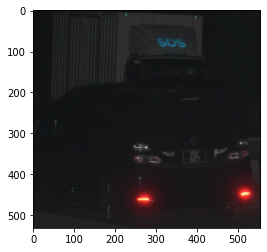

In [30]:
plt.imshow(img)

In [31]:
img.shape

(531, 555, 3)

In [32]:
img

array([[[16, 20, 19],
        [15, 19, 18],
        [13, 17, 16],
        ...,
        [20, 20, 22],
        [20, 20, 22],
        [21, 21, 23]],

       [[15, 19, 18],
        [15, 19, 18],
        [15, 19, 18],
        ...,
        [21, 21, 23],
        [21, 21, 23],
        [21, 21, 23]],

       [[15, 19, 18],
        [17, 21, 20],
        [18, 22, 21],
        ...,
        [20, 20, 22],
        [20, 20, 22],
        [20, 20, 22]],

       ...,

       [[33, 33, 35],
        [33, 33, 35],
        [35, 35, 37],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [32, 32, 32]],

       [[31, 31, 33],
        [32, 32, 34],
        [34, 34, 36],
        ...,
        [31, 31, 31],
        [31, 31, 31],
        [31, 31, 31]],

       [[29, 29, 31],
        [30, 30, 32],
        [33, 33, 35],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [29, 29, 29]]], dtype=uint8)

In [29]:
zig = perform_image_enhancement(img)

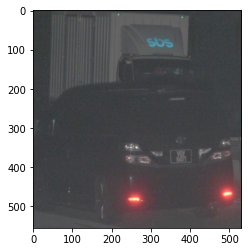

In [30]:
plt.imshow(zig)

(531, 555, 3)

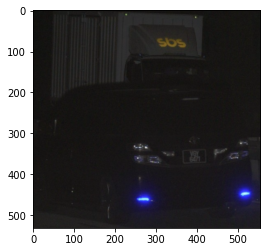

In [23]:
img = cv2.imread(r"C:\Users\Sean Tan\Desktop\robot_dev\scene_a_fullbody_w_lp\0030D60CAFF0_0000913_092-520_0.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

In [9]:
class DCENet(nn.Module):
    '''https://li-chongyi.github.io/Proj_Zero-DCE.html'''

    def __init__(self, n=8, return_results=[4, 6, 8]):
        '''
        Args
        --------
          n: number of iterations of LE(x) = LE(x) + alpha * LE(x) * (1-LE(x)).
          return_results: [4, 8] => return the 4-th and 8-th iteration results.
        '''
        super().__init__()
        self.n = n
        self.ret = return_results

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=True)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=True)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=True)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=True)
        self.conv7 = nn.Conv2d(64, 3 * n, kernel_size=3, padding=1, bias=True)

        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out1 = self.relu(self.conv1(x))

        out2 = self.relu(self.conv2(out1))
        out3 = self.relu(self.conv3(out2))
        out4 = self.relu(self.conv4(out3))

        out5 = self.relu(self.conv5(torch.cat((out4, out3), 1)))
        out6 = self.relu(self.conv6(torch.cat((out5, out2), 1)))

        alpha_stacked = self.tanh(self.conv7(torch.cat((out6, out1), 1)))

        alphas = torch.split(alpha_stacked, 3, 1)
        results = [x]
        for i in range(self.n):
            # x = x + alphas[i] * (x - x**2)  # as described in the paper
            # sign doesn't really matter becaus of symmetry.
            x = x + alphas[i] * (torch.pow(x, 2) - x)
            if i + 1 in self.ret:
                results.append(x)

        return results, alpha_stacked

In [18]:
ori = cv2.imread(r"C:\Users\Sean Tan\Desktop\robot_dev\scene_a_fullbody_w_lp\0030D60CAFF0_0000913_092-520_0.jpg")

In [10]:
device = torch.device('cpu')
model = DCENet(return_results=[4, 8])
model.load_state_dict(torch.load("C:/Users/Sean Tan/Desktop/zerodce/Zero-DCE/train-jobs/ckpt/8LE-color-loss2_best_model.pth",map_location=torch.device('cpu'))['model'])
model.to(device)

DCENet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

In [16]:
h = 555
w = 531
enh_our = read_image((r"C:\Users\Sean Tan\Desktop\zerodce\2.jpg"), h, w)
ori = read_image(r"C:\Users\Sean Tan\Desktop\robot_dev\scene_a_fullbody_w_lp\0030D60CAFF0_0000913_092-520_0.jpg", h, w)

In [22]:
img = torch.from_numpy(np.array(img))
img = img.float().div(255)
img = img.permute((2, 0, 1)).contiguous()
img = img.unsqueeze(0)
img = img.to(device)
results, Astack = model(img)
enhanced_image = results[1]

In [23]:
enhanced_image

tensor([[[[0.2046, 0.2339, 0.2399,  ..., 0.2858, 0.2631, 0.2316],
          [0.2303, 0.2518, 0.2667,  ..., 0.2961, 0.2898, 0.2786],
          [0.2626, 0.2919, 0.3042,  ..., 0.2894, 0.2851, 0.2821],
          ...,
          [0.3519, 0.3539, 0.3696,  ..., 0.3388, 0.3377, 0.3355],
          [0.3126, 0.3367, 0.3584,  ..., 0.3293, 0.3294, 0.3214],
          [0.2570, 0.3020, 0.3436,  ..., 0.3208, 0.3085, 0.2692]],

         [[0.2452, 0.2768, 0.2788,  ..., 0.2872, 0.2650, 0.2280],
          [0.2746, 0.2935, 0.3054,  ..., 0.2993, 0.2904, 0.2765],
          [0.3034, 0.3331, 0.3459,  ..., 0.2906, 0.2850, 0.2805],
          ...,
          [0.3605, 0.3627, 0.3772,  ..., 0.3663, 0.3633, 0.3594],
          [0.3224, 0.3461, 0.3666,  ..., 0.3555, 0.3534, 0.3413],
          [0.2684, 0.3107, 0.3514,  ..., 0.3480, 0.3265, 0.2841]],

         [[0.1501, 0.1645, 0.1642,  ..., 0.2169, 0.2084, 0.1901],
          [0.1654, 0.1750, 0.1861,  ..., 0.2250, 0.2254, 0.2198],
          [0.1847, 0.2064, 0.2186,  ..., 0

In [35]:
enhanced_image.shape

torch.Size([1, 3, 531, 555])

In [10]:
_,_,ww,hh = enhanced_image.shape

In [ ]:
images[0].permute(1, 2, 0).numpy()

In [31]:
enhanced_image.squeeze(0)

tensor([[[0.2046, 0.2339, 0.2399,  ..., 0.2858, 0.2631, 0.2316],
         [0.2303, 0.2518, 0.2667,  ..., 0.2961, 0.2898, 0.2786],
         [0.2626, 0.2919, 0.3042,  ..., 0.2894, 0.2851, 0.2821],
         ...,
         [0.3519, 0.3539, 0.3696,  ..., 0.3388, 0.3377, 0.3355],
         [0.3126, 0.3367, 0.3584,  ..., 0.3293, 0.3294, 0.3214],
         [0.2570, 0.3020, 0.3436,  ..., 0.3208, 0.3085, 0.2692]],

        [[0.2452, 0.2768, 0.2788,  ..., 0.2872, 0.2650, 0.2280],
         [0.2746, 0.2935, 0.3054,  ..., 0.2993, 0.2904, 0.2765],
         [0.3034, 0.3331, 0.3459,  ..., 0.2906, 0.2850, 0.2805],
         ...,
         [0.3605, 0.3627, 0.3772,  ..., 0.3663, 0.3633, 0.3594],
         [0.3224, 0.3461, 0.3666,  ..., 0.3555, 0.3534, 0.3413],
         [0.2684, 0.3107, 0.3514,  ..., 0.3480, 0.3265, 0.2841]],

        [[0.1501, 0.1645, 0.1642,  ..., 0.2169, 0.2084, 0.1901],
         [0.1654, 0.1750, 0.1861,  ..., 0.2250, 0.2254, 0.2198],
         [0.1847, 0.2064, 0.2186,  ..., 0.2166, 0.2176, 0.

In [ ]:
enhanced_image[0].permute(1, 2, 0).numpy()

In [36]:
np.log(enhanced_image[0].permute(1, 2, 0).detach().numpy().mean())

-1.2390869

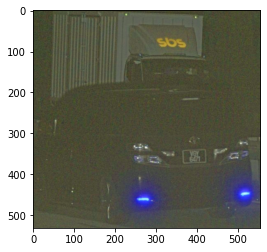

In [34]:
plt.imshow(enhanced_image[0].permute(1, 2, 0).detach().numpy())

TypeError: Invalid shape (3, 531, 555) for image data

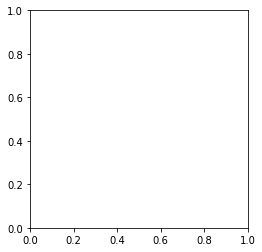

In [32]:
plt.imshow(enhanced_image.squeeze().detach().numpy())

In [13]:
def read_image(fp, h, w):
    fp = str(fp)
    img = cv2.imread(fp)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.
    img = cv2.resize(img, (w, h))
    return img

In [41]:
enh_our.shape

(555, 531, 3)

In [42]:
enh_our

array([[[0.17263764, 0.25891215, 0.16871607],
        [0.17700233, 0.26327684, 0.17308076],
        [0.18431373, 0.27058824, 0.18039216],
        ...,
        [0.2540822 , 0.28545475, 0.23358812],
        [0.23635759, 0.26773014, 0.21674975],
        [0.21996234, 0.24366899, 0.20418744]],

       [[0.19122225, 0.27749676, 0.18730068],
        [0.20658852, 0.29286303, 0.20266695],
        [0.21648975, 0.30276426, 0.21256818],
        ...,
        [0.27519448, 0.30656703, 0.2547004 ],
        [0.26544654, 0.29681909, 0.2458387 ],
        [0.25288423, 0.27659089, 0.23710933]],

       [[0.22422702, 0.30000868, 0.21331022],
        [0.25084925, 0.32663092, 0.23993245],
        [0.26300498, 0.33878664, 0.25208818],
        ...,
        [0.27237088, 0.30374342, 0.2518768 ],
        [0.26396666, 0.29533921, 0.24435882],
        [0.25508879, 0.28563259, 0.23589532]],

       ...,

       [[0.31129914, 0.34267168, 0.29953443],
        [0.33530041, 0.36667295, 0.3235357 ],
        [0.34172557, 0

In [43]:
ori

array([[[0.06265648, 0.07834275, 0.07442118],
        [0.05829179, 0.07397807, 0.0700565 ],
        [0.05053728, 0.06622355, 0.06230198],
        ...,
        [0.07887449, 0.07887449, 0.08671762],
        [0.07843137, 0.07843137, 0.08627451],
        [0.08226432, 0.08226432, 0.09010746]],

       [[0.05907215, 0.07475843, 0.07083686],
        [0.05878904, 0.07447531, 0.07055374],
        [0.05787167, 0.07355794, 0.06963638],
        ...,
        [0.08129857, 0.08129857, 0.0891417 ],
        [0.08209857, 0.08209857, 0.08994171],
        [0.08234719, 0.08234719, 0.09019033]],

       [[0.05898161, 0.07466789, 0.07074632],
        [0.06605589, 0.08174216, 0.07782059],
        [0.06887326, 0.08455953, 0.08063797],
        ...,
        [0.07836431, 0.07836431, 0.08620744],
        [0.07885533, 0.07885533, 0.08669846],
        [0.07885533, 0.07885533, 0.08669846]],

       ...,

       [[0.12857344, 0.12857344, 0.13641658],
        [0.12951955, 0.12951955, 0.13736269],
        [0.13648364, 0

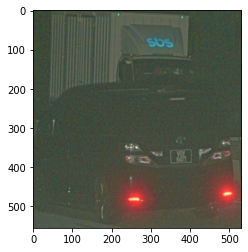

In [37]:
plt.imshow(enh_our)

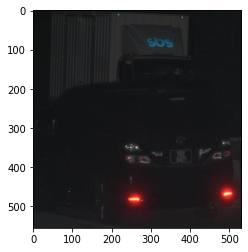

In [38]:
plt.imshow(ori)

In [39]:
gamma_alike = utils.gamma_like(ori, enh_our)

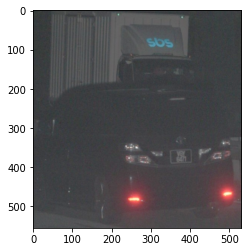

In [40]:
plt.imshow(gamma_alike)

In [106]:
def gamma_correction(img, gamma):
    return np.power(img, gamma)

In [105]:
def gamma_like2(img, enhanced):
    x, y = img.mean(), enhanced.mean()
    gamma = np.log(y) / np.log(x)
    return gamma_correction(img, gamma)

In [98]:
aa = transform

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [99]:
gamma_alike.shape

(531, 555, 3)

In [104]:
gamma_alike.transpose((1, 2, 0)).shape

(555, 3, 531)

In [101]:
enhanced_image.squeeze(0).shape

torch.Size([3, 531, 555])

In [124]:
flt = gamma_alike.astype('float32')

In [128]:
flt2 = utils.gamma_like(ori,detach)

In [129]:
show = transform(flt)
plt.imshow(show)

TypeError: Input type float32 is not supported

In [113]:
type(gamma_alike)

numpy.ndarray

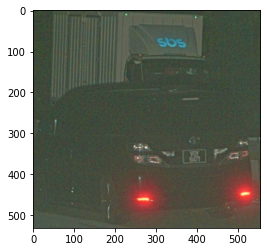

In [80]:
import torchvision.transforms as T
transform = T.ToPILImage()
img = transform(enhanced_image.squeeze(0))
plt.imshow(img)

In [42]:
torchvision.utils.save_image(enhanced_image,r"C:\Users\Sean Tan\Desktop\zerodce\2.jpg")

In [132]:
torchvision.utils.save_image(gamma_alike,r"C:\Users\Sean Tan\Desktop\zerodce\flt.jpg")

TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>